In [1]:
! pip install music21
! pip install np_utils

     -------------------------------------- 62.0/62.0 kB 821.4 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56459 sha256=6675c27ea3ec0d25a47c3e5585e3f3dac885ef0529a62750c0f99159c77c6033
  Stored in directory: c:\users\asus\appdata\local\pip\cache\wheels\65\07\4b\1c96f437e1bec60b3d2acd0b81d0a7969505f5251efbb5a060
Successfully built np_utils


In [1]:
import torch
import glob
import pickle
import numpy as np
from music21 import converter, instrument, note, chord
from tqdm import tqdm

In [2]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split

from tqdm import tqdm

import numpy as np
import csv

import os
import os.path as op

import random 
import math

from typing import List
from sklearn.model_selection import train_test_split

In [3]:
device = torch.device("cuda")

In [4]:
class Undertale(Dataset):

    def __init__(self, pkl_path , sequence_length, use_embedding=True, subset=None):
        super().__init__()
        self.pkl_path = pkl_path
        self.sequence_length = sequence_length
        self.use_embedding = use_embedding
        self.subset = subset

        with open(pkl_path, 'rb')as f:
            self.notes = pickle.load(f)
        if subset:
            self.notes = self.notes[:subset]
        
        self.n = len(set(self.notes))
        self.pitchnames = sorted(set(item for item in self.notes))
        self.note_to_int = dict((note,number) for number, note in enumerate(self.pitchnames))

        data = []
        label = []

        for i in range(0, len(self.notes) - sequence_length, 1):
            sequence_in = self.notes[i:i + sequence_length]
            sequence_out = self.notes[i + sequence_length]
            data.append([self.note_to_int[char] for char in sequence_in])
            label.append(self.note_to_int[sequence_out])

        n_patterns = len(data)

        self.data = torch.tensor(np.reshape(data, (n_patterns, sequence_length,1)))
        self.label = label
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):

        x, y = self.data[index], self.label[index]

        if self.use_embedding:
            return x, y
        else:
            x = x/float(self.n)
            return x, y

In [5]:
all_ds = Undertale("../data/notes_final.pkl",sequence_length=100,use_embedding=True)

In [6]:
train_ds, test_val_ds = train_test_split(all_ds,test_size=0.2) # apply train_test_split from sklearn to "all_ds"
val_ds, test_ds = train_test_split(test_val_ds,test_size=0.5) # apply train_test_split from sklearn to "test_val_ds"

In [7]:
trainloader = DataLoader(train_ds,batch_size=128,shuffle=True)
valloader = DataLoader(val_ds,batch_size=128,shuffle=False)
testloader = DataLoader(test_ds,batch_size=128,shuffle=True)

In [8]:
class TobyFox(nn.Module):
    def __init__(self,hidden_size=256,possible_notes=1140,embedding_dim=50):
        super().__init__()
        self.hidden_size = hidden_size
        self.possible_notes = possible_notes
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(self.possible_notes,embedding_dim)
        self.rnn = nn.LSTM(input_size = embedding_dim, hidden_size=hidden_size ,batch_first=True)
        self.output = torch.nn.Linear(in_features=hidden_size, out_features=possible_notes, bias=True, device=None, dtype=None)

    def init_hidden(self, size):
        return (torch.zeros(1, self.batch, size).to(device), torch.zeros(1, self.batch, size).to(device))

    def forward(self,x):

        self.batch = x.shape[0]

        h0, c0 = self.init_hidden(self.hidden_size)

        x = self.embedding(x)

        x = torch.squeeze(x, dim=-2)

        o1, (h1, c1) = self.rnn(x, (h0, c0))

        x = self.output(h1.view(self.batch, self.hidden_size))


        return x, (h1, c1)
        

In [9]:
test = train_ds[0][0].view(1, -1)

In [10]:
test

tensor([[1099,  922, 1127, 1099,  922, 1099,  922, 1077,  922, 1077,  922, 1077,
         1056,  169, 1056,  169, 1063,  169, 1063, 1070,   82, 1070,   82, 1084,
           82, 1084, 1056,  655, 1056,  655,  655, 1106,  655, 1106, 1092,  655,
         1092, 1127,  563, 1127,  563, 1099,  563, 1099,  563, 1077,  563, 1077,
         1056,  822, 1056,  822,  822, 1070,  822, 1070, 1127,  719, 1127,  719,
         1063,  719, 1063, 1056,  655, 1056,  655, 1106,  655, 1106, 1092,  655,
         1092, 1127,  563,  655, 1127,  563, 1099,  563, 1099, 1077,  563, 1077,
         1056,  822, 1056,  822, 1063,  822, 1063, 1070,  719, 1070,  719, 1084,
          719, 1084,  719, 1056]], dtype=torch.int32)

In [12]:
model = TobyFox(hidden_size=256,possible_notes=all_ds.n,embedding_dim=50).to(device)

In [11]:
all_ds.n

1140

In [14]:
model

TobyFox(
  (embedding): Embedding(1140, 50)
  (rnn): LSTM(50, 256, batch_first=True)
  (output): Linear(in_features=256, out_features=1140, bias=True)
)

In [15]:
loss_function = torch.nn.CrossEntropyLoss()

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [17]:
epochs = 50

In [18]:
running_loss = []
running_valid_loss = []
for i in range(epochs):
    
    model.train()

    # epoch loss
    epoch_loss = 0
    
    ## Training with loss logging
    pbar = tqdm(trainloader)
    pbar.set_description(f"Epoch - {i + 1} / {epochs}")
    for data, label in pbar:

        data, label = data.to(device), label.to(device)
        
        optimizer.zero_grad() # 1

        pred, hidden = model(data)

        loss = loss_function(pred, label)

        loss.backward() # 2

        optimizer.step() # 3

        epoch_loss += loss.item() * data.size(0)
        pbar.set_postfix({"loss" : loss.item()})
    

    print(f"Average CrossEntropyLoss of Epoch {i + 1} : {epoch_loss / len(trainloader.dataset)}")
    running_loss.append(epoch_loss / len(trainloader.dataset))

    model.eval()

    valid_loss = 0

    for data, label in valloader:

        data, label = data.to(device), label.to(device)

        pred, hidden = model(data)

        loss = loss_function(pred, label)

        valid_loss += loss.item() * data.size(0)

    print(f"Validation of Epoch {i + 1} : {epoch_loss / len(valloader.dataset)}")
    running_valid_loss.append(epoch_loss / len(valloader.dataset))



print("Finish training !")

Epoch - 1 / 50: 100%|██████████| 1469/1469 [00:15<00:00, 93.61it/s, loss=3.21] 


Average CrossEntropyLoss of Epoch 1 : 3.8606702415848555
Validation of Epoch 1 : 30.88519765582928


Epoch - 2 / 50: 100%|██████████| 1469/1469 [00:14<00:00, 102.15it/s, loss=2.67]


Average CrossEntropyLoss of Epoch 2 : 2.744444346383152
Validation of Epoch 2 : 21.955437991168772


Epoch - 3 / 50: 100%|██████████| 1469/1469 [00:14<00:00, 101.36it/s, loss=1.88]


Average CrossEntropyLoss of Epoch 3 : 2.294432912132223
Validation of Epoch 3 : 18.355365665769238


Epoch - 4 / 50: 100%|██████████| 1469/1469 [00:13<00:00, 106.92it/s, loss=2.14]


Average CrossEntropyLoss of Epoch 4 : 1.9907001974714469
Validation of Epoch 4 : 15.92551687272943


Epoch - 5 / 50: 100%|██████████| 1469/1469 [00:13<00:00, 107.35it/s, loss=1.96]


Average CrossEntropyLoss of Epoch 5 : 1.756335056271879
Validation of Epoch 5 : 14.050605715693253


Epoch - 6 / 50: 100%|██████████| 1469/1469 [00:13<00:00, 106.90it/s, loss=1.39]


Average CrossEntropyLoss of Epoch 6 : 1.5739366293373245
Validation of Epoch 6 : 12.591426061521737


Epoch - 7 / 50: 100%|██████████| 1469/1469 [00:13<00:00, 108.46it/s, loss=1.48]


Average CrossEntropyLoss of Epoch 7 : 1.421954966851578
Validation of Epoch 7 : 11.37557922866536


Epoch - 8 / 50: 100%|██████████| 1469/1469 [00:17<00:00, 82.31it/s, loss=1.25] 


Average CrossEntropyLoss of Epoch 8 : 1.2923816165300301
Validation of Epoch 8 : 10.338997939617947


Epoch - 9 / 50: 100%|██████████| 1469/1469 [00:14<00:00, 100.55it/s, loss=1.3]  


Average CrossEntropyLoss of Epoch 9 : 1.1857183052717184
Validation of Epoch 9 : 9.485695988222627


Epoch - 10 / 50: 100%|██████████| 1469/1469 [00:14<00:00, 104.08it/s, loss=1.19] 


Average CrossEntropyLoss of Epoch 10 : 1.0927159866719343
Validation of Epoch 10 : 8.741681396801427


Epoch - 11 / 50: 100%|██████████| 1469/1469 [00:14<00:00, 100.59it/s, loss=0.963]


Average CrossEntropyLoss of Epoch 11 : 1.0106548123690613
Validation of Epoch 11 : 8.08519549419472


Epoch - 12 / 50: 100%|██████████| 1469/1469 [00:13<00:00, 106.91it/s, loss=1.09] 


Average CrossEntropyLoss of Epoch 12 : 0.9387479854587383
Validation of Epoch 12 : 7.5099439386469085


Epoch - 13 / 50: 100%|██████████| 1469/1469 [00:14<00:00, 102.75it/s, loss=0.915]


Average CrossEntropyLoss of Epoch 13 : 0.8797387494777222
Validation of Epoch 13 : 7.037872561723251


Epoch - 14 / 50: 100%|██████████| 1469/1469 [00:14<00:00, 99.33it/s, loss=0.955] 


Average CrossEntropyLoss of Epoch 14 : 0.826918154065788
Validation of Epoch 14 : 6.615310046017045


Epoch - 15 / 50: 100%|██████████| 1469/1469 [00:14<00:00, 102.24it/s, loss=0.755]


Average CrossEntropyLoss of Epoch 15 : 0.7770899778436892
Validation of Epoch 15 : 6.216686756497956


Epoch - 16 / 50: 100%|██████████| 1469/1469 [00:14<00:00, 102.28it/s, loss=0.93] 


Average CrossEntropyLoss of Epoch 16 : 0.7324629428627546
Validation of Epoch 16 : 5.859672375592439


Epoch - 17 / 50: 100%|██████████| 1469/1469 [00:14<00:00, 102.73it/s, loss=0.669]


Average CrossEntropyLoss of Epoch 17 : 0.6972685025096776
Validation of Epoch 17 : 5.578118350339856


Epoch - 18 / 50: 100%|██████████| 1469/1469 [00:14<00:00, 104.32it/s, loss=0.74] 


Average CrossEntropyLoss of Epoch 18 : 0.6605872267091131
Validation of Epoch 18 : 5.284669704774274


Epoch - 19 / 50: 100%|██████████| 1469/1469 [00:14<00:00, 103.81it/s, loss=0.682]


Average CrossEntropyLoss of Epoch 19 : 0.6345300801404324
Validation of Epoch 19 : 5.076213640992395


Epoch - 20 / 50: 100%|██████████| 1469/1469 [00:13<00:00, 105.09it/s, loss=0.651]


Average CrossEntropyLoss of Epoch 20 : 0.6042164097743711
Validation of Epoch 20 : 4.8337055679524354


Epoch - 21 / 50: 100%|██████████| 1469/1469 [00:14<00:00, 101.79it/s, loss=0.844]


Average CrossEntropyLoss of Epoch 21 : 0.5909334047957884
Validation of Epoch 21 : 4.727442093333976


Epoch - 22 / 50: 100%|██████████| 1469/1469 [00:14<00:00, 101.78it/s, loss=0.461]


Average CrossEntropyLoss of Epoch 22 : 0.5564523362248598
Validation of Epoch 22 : 4.451595011983627


Epoch - 23 / 50: 100%|██████████| 1469/1469 [00:14<00:00, 101.31it/s, loss=0.601]


Average CrossEntropyLoss of Epoch 23 : 0.5386505705109335
Validation of Epoch 23 : 4.309181643761927


Epoch - 24 / 50: 100%|██████████| 1469/1469 [00:14<00:00, 104.20it/s, loss=0.634]


Average CrossEntropyLoss of Epoch 24 : 0.5211565062273933
Validation of Epoch 24 : 4.169229873890197


Epoch - 25 / 50: 100%|██████████| 1469/1469 [00:14<00:00, 104.64it/s, loss=0.73] 


Average CrossEntropyLoss of Epoch 25 : 0.5036829874287484
Validation of Epoch 25 : 4.029442467023391


Epoch - 26 / 50: 100%|██████████| 1469/1469 [00:14<00:00, 104.48it/s, loss=0.496]


Average CrossEntropyLoss of Epoch 26 : 0.48973013507882157
Validation of Epoch 26 : 3.9178202419371093


Epoch - 27 / 50: 100%|██████████| 1469/1469 [00:14<00:00, 104.71it/s, loss=0.361]


Average CrossEntropyLoss of Epoch 27 : 0.47306090469694684
Validation of Epoch 27 : 3.784467108180881


Epoch - 28 / 50: 100%|██████████| 1469/1469 [00:14<00:00, 104.00it/s, loss=0.459]


Average CrossEntropyLoss of Epoch 28 : 0.4681933199106362
Validation of Epoch 28 : 3.7455266370128495


Epoch - 29 / 50: 100%|██████████| 1469/1469 [00:14<00:00, 104.83it/s, loss=0.428]


Average CrossEntropyLoss of Epoch 29 : 0.4458856219561379
Validation of Epoch 29 : 3.5670660026002134


Epoch - 30 / 50: 100%|██████████| 1469/1469 [00:14<00:00, 104.37it/s, loss=0.344]


Average CrossEntropyLoss of Epoch 30 : 0.4392756036509536
Validation of Epoch 30 : 3.514186137424145


Epoch - 31 / 50: 100%|██████████| 1469/1469 [00:14<00:00, 103.92it/s, loss=0.494]


Average CrossEntropyLoss of Epoch 31 : 0.4321106960356923
Validation of Epoch 31 : 3.456867181378767


Epoch - 32 / 50: 100%|██████████| 1469/1469 [00:14<00:00, 100.81it/s, loss=0.721]


Average CrossEntropyLoss of Epoch 32 : 0.4212606409238515
Validation of Epoch 32 : 3.370067202168867


Epoch - 33 / 50: 100%|██████████| 1469/1469 [00:14<00:00, 101.90it/s, loss=0.374]


Average CrossEntropyLoss of Epoch 33 : 0.417815582789492
Validation of Epoch 33 : 3.3425068836859717


Epoch - 34 / 50: 100%|██████████| 1469/1469 [00:14<00:00, 102.46it/s, loss=0.444]


Average CrossEntropyLoss of Epoch 34 : 0.4110698472962626
Validation of Epoch 34 : 3.288541286780496


Epoch - 35 / 50: 100%|██████████| 1469/1469 [00:14<00:00, 100.75it/s, loss=0.639]


Average CrossEntropyLoss of Epoch 35 : 0.4064017302003083
Validation of Epoch 35 : 3.25119654864769


Epoch - 36 / 50: 100%|██████████| 1469/1469 [00:14<00:00, 102.18it/s, loss=0.473]


Average CrossEntropyLoss of Epoch 36 : 0.39754776008570164
Validation of Epoch 36 : 3.1803651644794906


Epoch - 37 / 50: 100%|██████████| 1469/1469 [00:14<00:00, 103.95it/s, loss=0.685]


Average CrossEntropyLoss of Epoch 37 : 0.39096597545567596
Validation of Epoch 37 : 3.127711167503309


Epoch - 38 / 50: 100%|██████████| 1469/1469 [00:14<00:00, 104.68it/s, loss=0.329]


Average CrossEntropyLoss of Epoch 38 : 0.38339373502514495
Validation of Epoch 38 : 3.0671335662683474


Epoch - 39 / 50: 100%|██████████| 1469/1469 [00:14<00:00, 104.79it/s, loss=0.423]


Average CrossEntropyLoss of Epoch 39 : 0.4039995344106286
Validation of Epoch 39 : 3.231979084547


Epoch - 40 / 50: 100%|██████████| 1469/1469 [00:14<00:00, 104.59it/s, loss=0.206]


Average CrossEntropyLoss of Epoch 40 : 0.37463550775368354
Validation of Epoch 40 : 2.9970681207713197


Epoch - 41 / 50: 100%|██████████| 1469/1469 [00:14<00:00, 101.26it/s, loss=0.452]


Average CrossEntropyLoss of Epoch 41 : 0.3794580767935194
Validation of Epoch 41 : 3.0356484678830347


Epoch - 42 / 50: 100%|██████████| 1469/1469 [00:14<00:00, 102.72it/s, loss=0.542]


Average CrossEntropyLoss of Epoch 42 : 0.3825626226374207
Validation of Epoch 42 : 3.0604847025315327


Epoch - 43 / 50: 100%|██████████| 1469/1469 [00:14<00:00, 104.31it/s, loss=0.516]


Average CrossEntropyLoss of Epoch 43 : 0.3909525706162285
Validation of Epoch 43 : 3.127603929358124


Epoch - 44 / 50: 100%|██████████| 1469/1469 [00:13<00:00, 105.21it/s, loss=0.457]


Average CrossEntropyLoss of Epoch 44 : 0.3963477779742646
Validation of Epoch 44 : 3.1707653586488904


Epoch - 45 / 50: 100%|██████████| 1469/1469 [00:14<00:00, 104.52it/s, loss=0.357]


Average CrossEntropyLoss of Epoch 45 : 0.3632907184016914
Validation of Epoch 45 : 2.9063102886918344


Epoch - 46 / 50: 100%|██████████| 1469/1469 [00:14<00:00, 104.69it/s, loss=0.501]


Average CrossEntropyLoss of Epoch 46 : 0.39421298799896887
Validation of Epoch 46 : 3.1536871296847853


Epoch - 47 / 50: 100%|██████████| 1469/1469 [00:14<00:00, 104.33it/s, loss=0.458]


Average CrossEntropyLoss of Epoch 47 : 0.38810051985599914
Validation of Epoch 47 : 3.104787644634987


Epoch - 48 / 50: 100%|██████████| 1469/1469 [00:14<00:00, 104.80it/s, loss=0.404]


Average CrossEntropyLoss of Epoch 48 : 0.378679505407652
Validation of Epoch 48 : 3.0294199299253832


Epoch - 49 / 50: 100%|██████████| 1469/1469 [00:14<00:00, 103.92it/s, loss=0.421]


Average CrossEntropyLoss of Epoch 49 : 0.39125298315455836
Validation of Epoch 49 : 3.1300072168817947


Epoch - 50 / 50: 100%|██████████| 1469/1469 [00:14<00:00, 104.68it/s, loss=0.481]


Average CrossEntropyLoss of Epoch 50 : 0.41447572614316297
Validation of Epoch 50 : 3.315788172630852
Finish training !


In [19]:
torch.save(model.state_dict() ,"tobyfox's_model_50_epochs_.pt")

In [17]:
model = TobyFox(hidden_size=256,possible_notes=all_ds.n,embedding_dim=50).to(device)
model.load_state_dict(torch.load("tobyfox's_model_50_epochs_.pt"))

<All keys matched successfully>

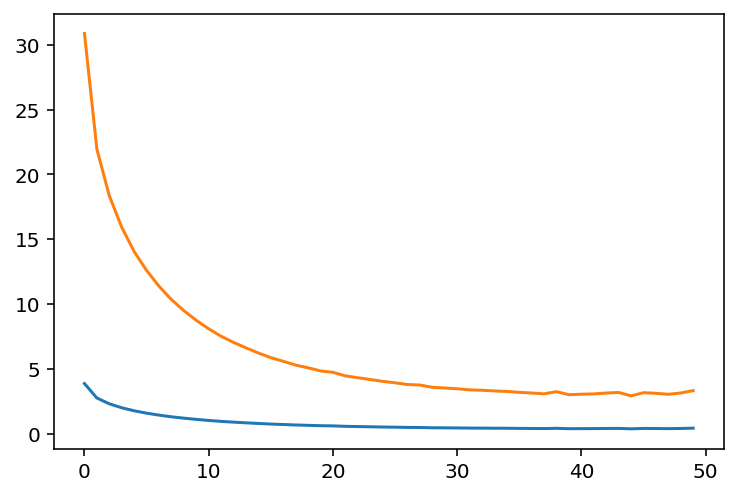

In [21]:
import matplotlib.pyplot as plt


plt.plot(np.arange(epochs), running_loss)
plt.plot(np.arange(epochs),  running_valid_loss)

In [24]:
def create_midi(prediction_output):
    from music21 import note, chord, instrument, stream
    import random
    offset = 0
    output_notes = []

        # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
            # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
            # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

            # increase offset each iteration so that notes do not stack
        offset += random.choice([0.25])

    midi_stream = stream.Stream(output_notes)

    midi_stream.write("midi", fp="peam's_model_midi_02.mid")

In [25]:
testing_model = model.eval().to(device)

start = np.random.randint(0, len(all_ds)-1)


pitchnames = sorted(set(item for item in all_ds.notes))
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
#pattern = all_ds.data[start]
pattern = torch.tensor(np.reshape(random.choices(list(range(len(int_to_note))), k=100), (100, 1)))
window_size = all_ds.sequence_length
prediction_output = []

# doing auto regressive generation
for note_indx in tqdm(range(200)):
    prediction_input = pattern.view(1, len(pattern), 1).to(device)[:, note_indx:note_indx+window_size, :]

    prediction, _ = testing_model(prediction_input)
    # get prediction
    index = torch.argmax(prediction, dim=-1)
    
    # get note from prediction
    result = int_to_note[index.item()]
    # add to output
    prediction_output.append(result)
    # add predicted note to the input sequence
    pattern = torch.cat((pattern.cpu(), torch.unsqueeze(index.cpu(), dim=0)), dim=0)

    

create_midi(prediction_output)

100%|██████████| 200/200 [00:00<00:00, 280.78it/s]
